In [1]:
import numpy as np

class Modeler:
    
    # nitems               - Maximal Bid
    # agent2_taxfree_limit - Maximal Bid for Agent 2 without taxes
    # agent2_tax           - Tax for Agent 2
    # strategy             - Supported strategy to make a bid
    #    "max"             - agent bets with max earnings
    #    "proportional"    - agent bets probabilistically, proportional to positive earnings
    # verbose              - print some additional imformation
    # max_iterations       - iterations limit. If none then models until converges.
    def __init__(self, 
                 nitems = 500, 
                 agent2_taxfree_limit = 399, 
                 agent2_tax = 10, 
                 strategy = "max",
                 verbose = False,
                 max_iterations = None
                ):
        self.nitems = nitems
        self.agent2_taxfree_limit = agent2_taxfree_limit
        self.agent2_tax = agent2_tax
        self.strategy = strategy.strip()
        self.verbose = verbose
        
        if self.strategy == "max":
            self.bet_strategy = self.max_bet_strategy
        elif self.strategy == "proportional":
            self.bet_strategy = self.proportional_bet_strategy
        else:
            raise ValueError('Unknown startegy {}. Supported strategies: ' +
                             '"max" or "proprtional". '
                             'You can use set_custom_strategy method to define your own bet strategy'
                            .format(strategy))
        
        self.max_iterations = max_iterations
    
    def set_custom_strategy(self, strategy):
        self.bet_strategy = strategy
    
        
    @staticmethod    
    def mae(p1, p2):
        return sum(np.absolute(np.subtract(p2, p1)))
    
    
    @staticmethod
    def normalize(vec):
        s = sum(vec)
        return np.multiply(vec, 1 / s)
    
    
    def calc_agent2_tax(self, b2):
        if b2 <= self.agent2_taxfree_limit:
            return 0
        else:
            return self.agent2_tax
    
        
    def proportional_bet_strategy(self, earnings):
        return Modeler.normalize(earnings)
    
    
    def max_bet_strategy(self, earnings):
        i = np.argmax(earnings)
        result = [0] * self.nitems
        result[i] = 1
        
        return result
    
    
    def apply_strategy(self, earnings):
        p = self.bet_strategy(earnings)
        if abs(sum(p) - 1) > 0.001:
            raise Exception("Incorrect bet strategy, sum != 1, while strategy should return probability")
            
        negative = list(filter(lambda x: x < -0.001, p))
        if negative:
            raise Exception('Incorrect bet strategy, there is a negative value ' +
                            'while strategy should return probability')
        
        return p
          
                            
    def calculate_agent1_probas(self, p2_win):
        # Earnings for every bet
        earnings = [(self.nitems - 1) / 2 - b1 for b1 in range(1, self.nitems + 1)]
        
        # Probability of win
        p2_win_sum = [p2_win[0]] * self.nitems
        for i in range(1, self.nitems):
            p2_win_sum[i] = p2_win_sum[i - 1] + p2_win[i]
        
        estimated_earnings = np.multiply(earnings, p2_win_sum)
        # Leave only positive earnings
        positive_earnings = np.clip(estimated_earnings, 0, self.nitems)
        if sum(positive_earnings) <= 1e-6:
            print("Zero estimated earnings for agent 1. Makes no sense to make a bet")
            return None
        
        return self.apply_strategy(positive_earnings)
        
    
    def calculate_agent2_probas(self, p1_win):
        # Earnings for every bet
        earnings = [(self.nitems - 1) / 2 - b2 - self.calc_agent2_tax(b2) \
                   for b2 in range(1, self.nitems + 1)]
        
        # Probability of win
        p1_win_sum = [0] * self.nitems
        for i in range(1, self.nitems):
            p1_win_sum[i] = p1_win_sum[i - 1] + p1_win[i - 1]
        
        estimated_earnings = np.multiply(earnings, p1_win_sum)
        # Leave only positive earnings
        positive_earnings = np.clip(estimated_earnings, 0, self.nitems)
        if sum(positive_earnings) <= 1e-6:
            print("Zero estimaged earnings for agent 2. Makes no sense to make a bet")
            return None
        
        return self.apply_strategy(positive_earnings)
        

    # MAE of probabilities for both agents should not be large than eps
    def model(self, eps = 0.001):
        
        p1_win = [1 / self.nitems] * self.nitems
        p2_win = [1 / self.nitems] * self.nitems
        
        t, converged = 0, False
        
        while not converged:
            p1_win_new = self.calculate_agent1_probas(p2_win)
            p2_win_new = self.calculate_agent2_probas(p1_win)
            
            if p1_win_new is None or p2_win_new is None:
                break
            
            p1_diff = Modeler.mae(p1_win, p1_win_new)
            p2_diff = Modeler.mae(p2_win, p2_win_new)
            if self.verbose:
                print('p1 = {}, p1_diff = {}'.format(np.argmax(p1_win_new), p1_diff))
                print('p2 = {}, p2_diff = {}'.format(np.argmax(p2_win_new), p2_diff))
                print()

            converged = abs(p1_diff) < eps and abs(p2_diff) < eps
            p1_win = p1_win_new
            p2_win = p2_win_new
            t += 1
            
            if self.max_iterations is not None and t >= self.max_iterations:
                break
        
        return (p1_win, p2_win)    

In [2]:
modeler = Modeler(
    nitems = 500, 
    agent2_taxfree_limit = 399,
    agent2_tax=10, 
    strategy = "proportional")

prop_p1, prop_p2 = modeler.model()
print("Sampling bets according to estimated earnings:")
print("Agent 1 bet: {}".format(np.argmax(prop_p1) + 1))
print("Agent 2 bet: {}".format(np.argmax(prop_p2) + 1))


Zero estimaged earnings for agent 2. Makes no sense to make a bet
Sampling bets according to estimated earnings:
Agent 1 bet: 249
Agent 2 bet: 249


In [3]:
modeler = Modeler(
    nitems = 500, 
    agent2_taxfree_limit = 399, 
    agent2_tax=10, 
    strategy = "max")

max_p1, max_p2 = modeler.model(1e-3)

print("Single bet with Max earning strategy:")
print("Agent 1 bet: {}".format(np.argmax(max_p1) + 1))
print("Agent 2 bet: {}".format(np.argmax(max_p2) + 1))


Zero estimaged earnings for agent 2. Makes no sense to make a bet
Single bet with Max earning strategy:
Agent 1 bet: 249
Agent 2 bet: 249


Probability is proportional to earnings


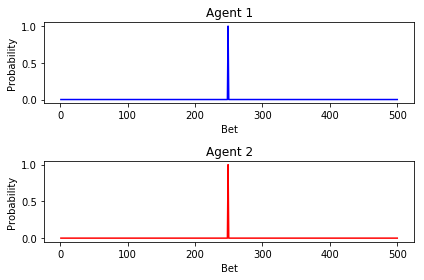

Probability is proportional to earnings


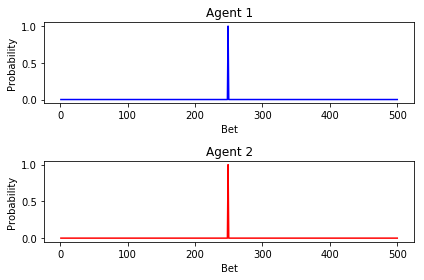

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

print('Probability is proportional to earnings')

plt.figure(1)
plt.subplot(211)
plt.title('Agent 1')
plt.plot(range(1, 501), prop_p1, 'b')
plt.ylabel('Probability')
plt.xlabel('Bet')

plt.subplot(212)
plt.title('Agent 2')
plt.plot(range(1, 501), prop_p1, 'r')
plt.ylabel('Probability')
plt.xlabel('Bet')
plt.tight_layout()

plt.show()

print('Probability is proportional to earnings')

plt.figure(1)
plt.subplot(211)
plt.title('Agent 1')
plt.plot(range(1, 501), max_p1, 'b')
plt.ylabel('Probability')
plt.xlabel('Bet')

plt.subplot(212)
plt.title('Agent 2')
plt.plot(range(1, 501), max_p1, 'r')
plt.ylabel('Probability')
plt.xlabel('Bet')
plt.tight_layout()

plt.show()